<a href="https://colab.research.google.com/github/lukeolson/imperial-multigrid/blob/master/lecture-3-amg-basics/20-AMG-advanced-options-nonsymmetric-flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# you may need to install pyamg
!pip install pyamg

In [1]:
import numpy as np
import scipy.io as sio
import pyamg
import scipy.sparse.linalg as sla

import matplotlib.pyplot as plt
from matplotlib import collections
from matplotlib import tri
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# recirculating flow

In [2]:
A = pyamg.gallery.load_example('recirc_flow')['A'].tocsr()

In [3]:
ml = pyamg.smoothed_aggregation_solver(A)

In [4]:
res = []
x = ml.solve(np.random.rand(A.shape[0]), residuals=res)
res = np.array(res)
res

array([8.29519662e+000, 1.48401566e+003, 3.79353700e+004, 1.00843269e+006,
       2.67947775e+007, 7.11938842e+008, 1.89162837e+010, 5.02607474e+011,
       1.33543288e+013, 3.54825798e+014, 9.42775549e+015, 2.50496368e+017,
       6.65571253e+018, 1.76842920e+020, 4.69873336e+021, 1.24845796e+023,
       3.31716479e+024, 8.81373866e+025, 2.34181882e+027, 6.22223507e+028,
       1.65325383e+030, 4.39271128e+031, 1.16714760e+033, 3.10112238e+034,
       8.23971192e+035, 2.18929936e+037, 5.81698941e+038, 1.54557967e+040,
       4.10662000e+041, 1.09113288e+043, 2.89915052e+044, 7.70307074e+045,
       2.04671329e+047, 5.43813684e+048, 1.44491818e+050, 3.83916146e+051,
       1.02006888e+053, 2.71033281e+054, 7.20138028e+055, 1.91341365e+057,
       5.08395842e+058, 1.35081263e+060, 3.58912212e+061, 9.53633191e+062,
       2.53381254e+064, 6.73236423e+065, 1.78879563e+067, 4.75284716e+068,
       1.26283605e+070, 3.35536751e+071, 8.91524365e+072, 2.36878879e+074,
       6.29389455e+075, 1

The error explodes.  Let's see what relaxation does (or does not) do

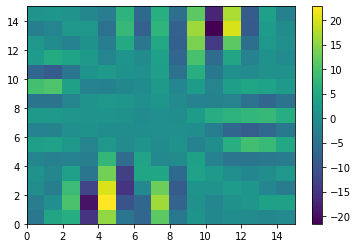

In [5]:
x = np.random.rand(A.shape[0])
pyamg.relaxation.relaxation.jacobi(A, x, 0*x, iterations=5, omega=4/3)
plt.pcolormesh(x.reshape(15,15))
plt.colorbar()

Since Jacobi requires (sufficient) a weakly diagonally dominant matrix, this may not be the right smoother.  Let's try Gauss-Seidel on $AA^T$

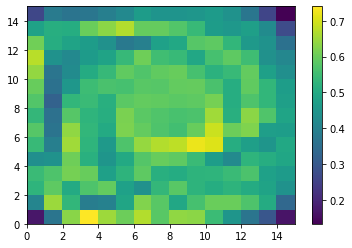

In [6]:
x = np.random.rand(A.shape[0])
pyamg.relaxation.relaxation.gauss_seidel_ne(A, x, 0*x, iterations=5, omega=4/3)
plt.pcolormesh(x.reshape(15,15))
plt.colorbar()

In [7]:
ml = pyamg.smoothed_aggregation_solver(A,
        presmoother=('gauss_seidel_nr', {'sweep': 'symmetric', 'iterations': 2}),
        postsmoother=('gauss_seidel_nr', {'sweep': 'symmetric', 'iterations': 2}),)

In [8]:
res = []
x = ml.solve(np.random.rand(A.shape[0]), residuals=res)
res = np.array(res)
res[1:]/res[:-1]

array([0.85066109, 0.98206973, 1.00708201, 1.01345384, 1.01104139,
       1.00653526, 1.00224894, 0.99877398, 0.99613842, 0.99421463,
       0.99285339, 0.99192336, 0.99131883, 0.99095772, 0.99077719,
       0.99072936, 0.99077781, 0.99089481, 0.99105926, 0.99125508,
       0.9914701 , 0.99169513, 0.9919233 , 0.99214953, 0.99237014,
       0.99258253, 0.99278493, 0.99297622, 0.99315578, 0.99332335,
       0.99347895, 0.99362282, 0.99375533, 0.99387697, 0.99398827,
       0.99408984, 0.99418227, 0.99426617, 0.99434215, 0.99441079,
       0.99447266, 0.99452829, 0.9945782 , 0.99462287, 0.99466274,
       0.99469824, 0.99472975, 0.99475763, 0.99478223, 0.99480384,
       0.99482275, 0.99483922, 0.99485349, 0.99486577, 0.99487627,
       0.99488516, 0.99489262, 0.99489879, 0.9949038 , 0.99490779,
       0.99491087, 0.99491314, 0.99491469, 0.99491561, 0.99491596,
       0.99491583, 0.99491527, 0.99491435, 0.99491309, 0.99491157,
       0.9949098 , 0.99490784, 0.99490571, 0.99490344, 0.99490

At least the problem doesn't blow up.

What does the solution look like?

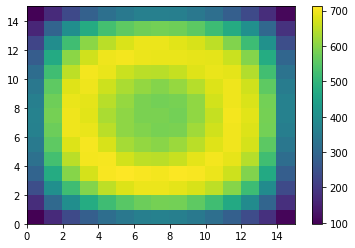

In [9]:
plt.pcolormesh(x.reshape(15,15))
plt.colorbar()

# Adding better strength

In [10]:
strength=('evolution', {'k': 2, 'proj_type': 'l2', 'epsilon': 4.0})
ml = pyamg.smoothed_aggregation_solver(A,
        presmoother=('gauss_seidel_nr', {'sweep': 'symmetric', 'iterations': 2}),
        postsmoother=('gauss_seidel_nr', {'sweep': 'symmetric', 'iterations': 2}),
                                      strength=strength)

In [11]:
res = []
x = ml.solve(np.random.rand(A.shape[0]), residuals=res)
res = np.array(res)
res[1:]/res[:-1]

array([0.91082252, 0.94341348, 0.96762722, 0.97433528, 0.97552746,
       0.97569365, 0.9756648 , 0.9756042 , 0.97554799, 0.9755019 ,
       0.97546462, 0.97543411, 0.97540879, 0.97538752, 0.97536944,
       0.97535388, 0.97534035, 0.97532848, 0.975318  , 0.97530873,
       0.97530052, 0.97529325, 0.97528684, 0.97528121, 0.97527627,
       0.97527196, 0.9752682 , 0.97526495, 0.97526215, 0.97525973,
       0.97525765, 0.97525587, 0.97525434, 0.97525304, 0.97525193,
       0.97525099, 0.97525018, 0.9752495 , 0.97524892, 0.97524843,
       0.97524802, 0.97524767, 0.97524737, 0.97524712, 0.97524691,
       0.97524673, 0.97524658, 0.97524645, 0.97524634, 0.97524625,
       0.97524617, 0.97524611, 0.97524605, 0.97524601, 0.97524597,
       0.97524593, 0.97524591, 0.97524588, 0.97524586, 0.97524585,
       0.97524583, 0.97524582, 0.97524581, 0.9752458 , 0.9752458 ,
       0.97524579, 0.97524578, 0.97524578, 0.97524578, 0.97524577,
       0.97524577, 0.97524577, 0.97524577, 0.97524577, 0.97524

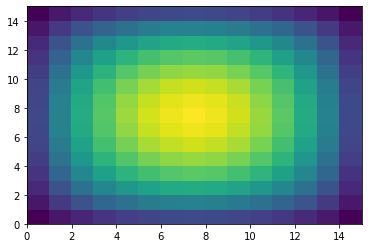

In [12]:
plt.pcolormesh(x.reshape(15,15))

# Improving the candidate vectors

In [13]:
improve_candidates=[('gauss_seidel_nr', {'sweep': 'symmetric', 'iterations': 4}), None, None, None, None, None, None, None, None, None, None, None, None, None, None]
ml = pyamg.smoothed_aggregation_solver(A,
        presmoother=('gauss_seidel_nr', {'sweep': 'symmetric', 'iterations': 2}),
        postsmoother=('gauss_seidel_nr', {'sweep': 'symmetric', 'iterations': 2}),
                                      strength=strength,
                                      improve_candidates=improve_candidates)

In [14]:
res = []
x = ml.solve(np.random.rand(A.shape[0]), residuals=res)
res = np.array(res)
res[1:]/res[:-1]

array([1.35296668, 0.78806105, 0.79713985, 0.811117  , 0.82207138,
       0.8299667 , 0.83540563, 0.83901073, 0.84131611, 0.84273456,
       0.84356297, 0.8440054 , 0.84419882, 0.84423428, 0.84417221,
       0.84405278, 0.84390259, 0.84373913, 0.84357369, 0.84341333,
       0.84326226, 0.84312274, 0.84299573, 0.84288136, 0.84277924,
       0.84268865, 0.84260871, 0.84253847, 0.84247695, 0.84242324,
       0.84237644, 0.84233574, 0.84230041, 0.84226979, 0.84224326,
       0.84222032, 0.84220048, 0.84218335, 0.84216856, 0.8421558 ,
       0.84214479, 0.8421353 , 0.84212712, 0.84212007, 0.84211399,
       0.84210876, 0.84210426, 0.84210038, 0.84209704, 0.84209417,
       0.84209169, 0.84208956, 0.84208773, 0.84208615, 0.8420848 ,
       0.84208363, 0.84208262, 0.84208176, 0.84208101, 0.84208037,
       0.84207982, 0.84207935, 0.84207894, 0.84207859, 0.84207829,
       0.84207803, 0.84207781, 0.84207761, 0.84207745])

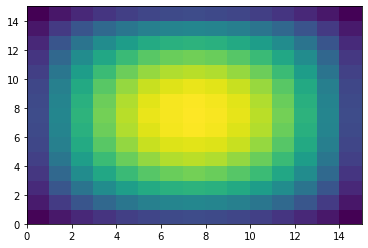

In [15]:
plt.pcolormesh(x.reshape(15,15))

# Adding energy minimization

In [16]:
smooth=('energy', {'krylov': 'gmres', 'maxiter': 2, 'degree': 1, 'weighting': 'local'})
ml = pyamg.smoothed_aggregation_solver(A,
        presmoother=('gauss_seidel_nr', {'sweep': 'symmetric', 'iterations': 2}),
        postsmoother=('gauss_seidel_nr', {'sweep': 'symmetric', 'iterations': 2}),
                                      strength=strength,
                                      improve_candidates=improve_candidates,
                                      smooth=smooth)

In [17]:
ml

multilevel_solver
Number of Levels:     3
Operator Complexity:  1.336
Grid Complexity:      1.253
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0          225         1849 [74.86%]
    1           50          572 [23.16%]
    2            7           49 [ 1.98%]

In [18]:
res = []
x = ml.solve(np.random.rand(A.shape[0]), residuals=res)
res = np.array(res)
res[1:]/res[:-1]

array([1.22785021, 0.78887874, 0.78999328, 0.81072094, 0.82712026,
       0.83850751, 0.84599665, 0.85064763, 0.853293  , 0.85456678,
       0.85493925, 0.85474762, 0.8542253 , 0.85352856, 0.8527587 ,
       0.85197906, 0.8512275 , 0.85052507, 0.84988205, 0.84930191,
       0.848784  , 0.84832522, 0.84792125, 0.84756714, 0.84725786,
       0.8469885 , 0.84675442, 0.84655138, 0.84637553, 0.84622342,
       0.84609196, 0.84597845, 0.84588051, 0.84579605, 0.84572326,
       0.84566054, 0.84560652, 0.84556001, 0.84551997, 0.84548552,
       0.84545587, 0.84543036, 0.84540842, 0.84538955, 0.84537332,
       0.84535936, 0.84534736, 0.84533704, 0.84532817, 0.84532054,
       0.84531398, 0.84530834, 0.8453035 , 0.84529933, 0.84529575,
       0.84529267, 0.84529002, 0.84528775, 0.84528579, 0.84528411,
       0.84528267, 0.84528142, 0.84528036, 0.84527944, 0.84527865,
       0.84527797, 0.84527739, 0.84527689, 0.84527646, 0.84527609,
       0.84527577])

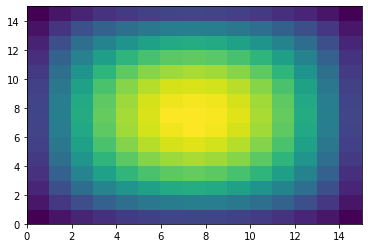

In [19]:
plt.pcolormesh(x.reshape(15,15))

# Oh, right!  A Krylov accelerator

In [20]:
res = []
x = ml.solve(np.random.rand(A.shape[0]), residuals=res, accel='gmres')
res = np.array(res)
res[1:]/res[:-1]

array([0.11554564, 0.4327797 , 0.67371083, 0.41975428, 0.23181183,
       0.25078713, 0.28657054, 0.29240572, 0.27934264, 0.29214252])

In [ ]:
res